In [0]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import copy
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import load_model
%matplotlib inline

In [14]:
import json

data = {} #global variable

def translation_to_dictionary(): #Create Dictionary from the dataset
    filename = 'dataset.txt'

    with open(filename) as fh:
        for line in fh:
            d, description = line.strip().split(';', 1)
            data[d] = description.strip()

    return json.dumps(data, indent=2, sort_keys=True) #return dictionary: data


def labels_to_english(key): #Get the english translation of the label
    return data[key]

translation_to_dictionary()


'{\n  "A55": "lie down",\n  "Aa15": "Unknown",\n  "Aa26": "Unknown",\n  "Aa27": "Unknown",\n  "Aa28": "Unknown",\n  "D1": "head",\n  "D10": "Udjat-eye",\n  "D156": "Unknown",\n  "D19": "nose,eye and cheek",\n  "D2": "face",\n  "D21": "mouth",\n  "D28": "close",\n  "D34": "arms with shield and battle axe",\n  "D35": "not",\n  "D36": "forearm",\n  "D39": "forearm with bowl",\n  "D4": "eye",\n  "D46": "hand",\n  "D52": "man-like",\n  "D53": "in before",\n  "D54": "approach",\n  "D56": "leg",\n  "D58": "place",\n  "D60": "purely",\n  "D62": "toe",\n  "E1": "bull",\n  "E17": "jackal",\n  "E23": "lying lion",\n  "E34": "hare",\n  "E9": "newborn",\n  "F12": "head and neck of animal",\n  "F13": "horns",\n  "F16": "horn",\n  "F18": "tusk",\n  "F21": "ear of bovine",\n  "F22": "hind-quarters of lion",\n  "F23": "foreleg of ox",\n  "F26": "skin of goat",\n  "F29": "cow\'s skin pierced by arrow",\n  "F30": "water-skin",\n  "F31": "three skins tied together",\n  "F32": "animal\'s belly",\n  "F34": 

In [0]:
##Create function to loop over array of images and shows it
def imshow_array(array):
  for i in range(len(array)):
    plt.subplot(1,len(array),i+1),plt.imshow(array[i],'gray')
    plt.xticks([]),plt.yticks([])

In [0]:

def edge_detection(im):
  cv2.pyrUp(im,im)
  im = cv2.GaussianBlur(im,(5,5),5)

  th,bw1 = cv2.threshold(im, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
  bw1 = cv2.Canny(im, th, th/2,True,5)
  bw2 = cv2.Canny(im, th, th/2,True,3)
  
  k = np.array([[0, 0, 1],
              [0, -1, 0],
              [1, 0, 0]])
  hitmiss = cv2.morphologyEx(bw1, cv2.MORPH_HITMISS, k)
  bw1 |= hitmiss
  kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3, 3))
  prevMu = 0
  recons = copy.copy(bw2)
  for i  in range(350):

    recons = cv2.dilate(recons, kernel)
    recons &= bw1
    
  return recons




In [0]:
## After the vertical lines detection, if the distance between the lines very small (8 pixels), then it's too small to contain a hieroglyph and deleting one of the lines
def filter_lines(lines_start_point):
  small_dist_found = False
  min_dist = 8
  length = len(lines_start_point)
  new_lines_list =copy.copy(lines_start_point) 
  
  for i in range(length-1): #loop over list of vertical lines detected
    x_dist = lines_start_point[i+1]-lines_start_point[i] 
  
    if x_dist <= min_dist:
      small_dist_found = True
      x_mid = (lines_start_point[i+1]+lines_start_point[i])/2 #repleace one of the lines with mid distance between the 2 lines and delete the other line
      new_lines_list[i]=x_mid
      new_lines_list[i+1] =-1
  while -1 in new_lines_list: new_lines_list.remove(-1)
  if small_dist_found: ##repeat the process to check that there's no lines with less than 8 ppixel distance
    new_lines_list = filter_lines(new_lines_list)
  return new_lines_list

In [0]:
def vertical_line_detection(hiero):
  kernel = np.ones((5,5),np.uint8) 
  temp1 = cv2.morphologyEx(hiero, cv2.MORPH_BLACKHAT, kernel)
  temp2 = cv2.medianBlur(temp1,5)
  temp3 = cv2.Canny(temp2,0,255,L2gradient=True)
  image_height = hiero.shape[0]
  lines = cv2.HoughLines(temp3,1,np.pi/180, int(image_height/6))
  copy = hiero[:]
  lines_start_point = []

  for line in lines:    
    for rho,theta in line:
      if theta != 0:
        continue
      a = np.cos(theta)
      b = np.sin(theta)
      x0 = a*rho
      y0 = b*rho
      x1 = int(x0 + 1000*(-b))
      y1 = int(y0 + 1000*(a))
      x2 = int(x0 - 1000*(-b))
      y2 = int(y0 - 1000*(a))
      cv2.line(copy,(x1,y1),(x2,y2),(255,0,0),2)
      lines_start_point.append(x1)
  lines_start_point.sort()
  listos = filter_lines(lines_start_point)
  tany = hiero[:]
  y = tany.shape[0]
  for x in listos:
    cv2.line(tany,(int(x),0),(int(x),y),(255,0,0),2)
  return tany,listos

In [0]:
def crop_image(image,lines): ##cut the original image into list of hieroglyphic columns
  cropped=[]
  for i in range(len(lines)-1):
    cropped.append(hiero[:,int(lines[i]):int(lines[i+1])])
  final_list = []
  
  for i in range(len(cropped)): ##check if col width less than 60 then it's not a useful one 
    if cropped[i].shape[1]<60:
      continue 
    final_list.append(cropped[i])
  return final_list

In [0]:
def Morph_array(array,kernel,morph): ##simple function to apply morphological filters to array of images
  return_array = []
  for i in range(len(array)):
    if morph == 'dilate':
      return_array.append(cv2.dilate(array[i],kernel))
    if morph == 'erode':
      return_array.append(cv2.erode(array[i],kernel))
    if morph == 'edge':
      return_array.append(edge_detection(array[i]))
    if morph == 'new_edge':
      return_array.append(edge_new(array[i]))
    if morph == 'bilateral':
      return_array.append(cv2.bilateralFilter(array[i],5,75,75))
    if morph=='filter2d':
      return_array.append(cv2.filter2D(array[i], -1, kernel))
  return return_array
     
     
       

In [0]:
def new_edge(array):
  dilate=[]
  kerneledge = np.array([[-1,-1,-1], 
                    [-1, 9,-1],
                    [-1,-1,-1]])
  kernel = np.ones((3,3),np.uint8)  
  dst = Morph_array(array,kerneledge,'bilateral')
  sharpened = Morph_array(dst,kerneledge,'filter2d')
  edge_of_sharp = Morph_array(sharpened,kernel,'edge')
  #dilate = Morph_array(edge_of_sharp,kernel,'dilate')
  return edge_of_sharp

In [0]:
def draw_rec(cropped_col,stats):
  img_copy = copy.copy(cropped_col)
  col_area = cropped_col.shape[0]*cropped_col.shape[1]
  dirName = '/content/images'
  if not os.path.exists(dirName):
    os.makedirs(dirName)
    print("Directory " , dirName ,  " Created ")
  else:    
    print("Directory " , dirName ,  " already exists")
  
  blocks =[]
  i =0
  for left,top,width,height,area in stats:
    if area<300 or area == col_area or height==cropped_col.shape[0] or width<20:
      #i +=1
      continue
    blocks.append(cropped_col[top:top+height,left:left+width])
    filename = "/content/images/file_%i.jpg"%i
    cv2.imwrite(filename, blocks[i])
    cv2.rectangle(img_copy, (left,top), (left+width,top+height),(0,255,0),2) 
    i +=1
  return blocks,img_copy


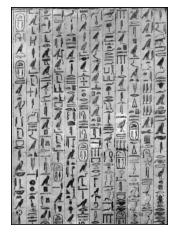

In [23]:
hiero = cv2.imread('/content/egyptianTexts5.jpg',0)
cv2.imwrite('image.jpg', hiero, [int(cv2.IMWRITE_JPEG_QUALITY), 100])
kernel = np.ones((3,3),np.uint8)
kerneledge = np.array([[-1,-1,-1], 
                    [-1, 9,-1],
                    [-1,-1,-1]])

dst = cv2.bilateralFilter(hiero,5,75,75)
plt.imshow(dst,'gray')
plt.xticks([]),plt.yticks([])
sharpend = cv2.filter2D(dst, -1, kerneledge)
edge_of_sharp= edge_detection(sharpend)
dilate = cv2.dilate(edge_of_sharp,kernel)



[15.0, 110.0, 206.0, 301.5, 393.0, 485.5, 577.0, 668, 762.0, 856.25, 948.0, 1047.0, 1141.0]


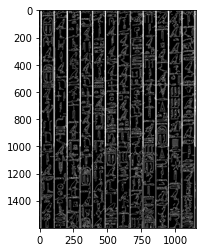

In [24]:
line_det,lines_list = vertical_line_detection(edge_of_sharp)
plt.imshow(line_det,'gray')
print(lines_list)

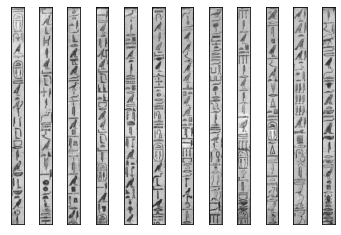

In [25]:
crop_list = crop_image(sharpend,lines_list)
imshow_array(crop_list)

In [0]:

edged = Morph_array(crop_list,kernel,'edge')
edged_dilated = Morph_array(edged,kernel,'dilate')


In [0]:
sharpened_edges = new_edge(crop_list)



In [0]:

index = 0

retval, labels, stats, centroids	=	cv2.connectedComponentsWithStats(edged_dilated[index])

Directory  /content/images  Created 


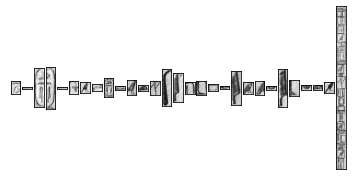

In [29]:
cutouts, rec = draw_rec(crop_list[index],stats)
imshow_array(cutouts)
cv2.imwrite('nw_edge_rec1-.jpg',rec)
plt.imshow(rec,'gray')

In [0]:
model = load_model('/content/model')
label_dict = np.load('label_dict.npy',allow_pickle='TRUE').item()

In [31]:
import glob
##After Saving cutted out images in folder, re-reading as 3D Array to be reshaped and Fed to Model
X_data = []
files = glob.glob ("/content/images/*.jpg")
for myFile in files:
    print(myFile)
    image = cv2.resize(cv2.imread (myFile,0),(50,75))
    X_data.append (image)
X_data = np.array(X_data)
X_data_reshaped = X_data.reshape((X_data.shape[0],3750))
print('X_data shape:', X_data.shape)
print(X_data[0].shape)

/content/images/file_24.jpg
/content/images/file_11.jpg
/content/images/file_9.jpg
/content/images/file_27.jpg
/content/images/file_14.jpg
/content/images/file_15.jpg
/content/images/file_25.jpg
/content/images/file_10.jpg
/content/images/file_13.jpg
/content/images/file_16.jpg
/content/images/file_26.jpg
/content/images/file_22.jpg
/content/images/file_12.jpg
/content/images/file_17.jpg
/content/images/file_18.jpg
/content/images/file_5.jpg
/content/images/file_23.jpg
/content/images/file_8.jpg
/content/images/file_4.jpg
/content/images/file_6.jpg
/content/images/file_19.jpg
/content/images/file_0.jpg
/content/images/file_28.jpg
/content/images/file_21.jpg
/content/images/file_7.jpg
/content/images/file_1.jpg
/content/images/file_2.jpg
/content/images/file_20.jpg
/content/images/file_3.jpg
X_data shape: (29, 75, 50)
(75, 50)


In [32]:
print(X_data.shape)

(29, 75, 50)


In [0]:
preds = model.predict(X_data_reshaped/255.)

In [34]:
print(preds.shape)

(29, 171)


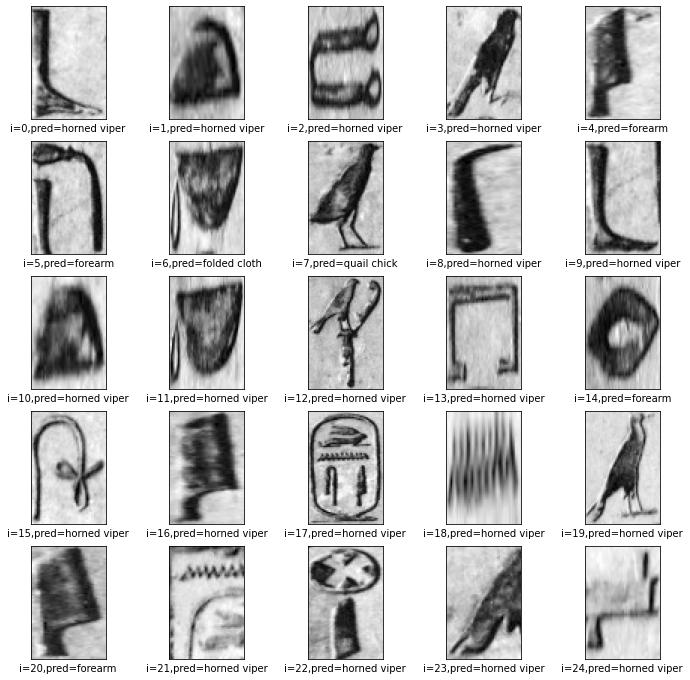

In [37]:
plt.figure(figsize=(12,12))
Predicted_labels_list =[]
start_index=0
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    pred=np.argmax(preds[start_index+i])
    label_pred = label_dict[pred]
    English_pred = labels_to_english(label_pred)
    Predicted_labels_list.append(label_pred)

    plt.xlabel('i={},pred={}'.format(start_index+i,English_pred))
    plt.imshow(X_data[start_index+i],cmap='gray')
plt.show()